# Model Training 

### Import Dependencies

In [2]:
import os
from multiprocessing import Pool
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn.linear_model
import sklearn.preprocessing
import sklearn.metrics

random.seed(42)

### Loading Data
We will load the data from both the training and test set this time.

In [3]:
train_CSV = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
test_CSV = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'

train_df = pd.read_csv(train_CSV, delimiter=' ', names=['SPEAKER_ID', 'AUDIO_FILE_NAME', 'SYSTEM_ID', '-', 'KEY'])
test_df = pd.read_csv(test_CSV, delimiter=' ', names=['SPEAKER_ID', 'AUDIO_FILE_NAME', 'SYSTEM_ID', '-', 'KEY'])

# Extract the files' labels
train_labels = np.array(train_df['KEY'].map(lambda x: x == 'bonafide'))
test_labels = test_df['KEY'].map(lambda x: x == 'bonafide')


### Extracting MFCC Features
This function will extract 25 different MFCC features from each file, and calculate the mean and standard deviation. MFCC stands for *Mel Frequency Cepstral Coefficents* which is a way of representing sound, especially speech. Then, it will conmbine all values into a single vector.

This snippet also uses multiprocessing to speed up the process in parallel.

In [4]:
from mfcc_extraction import extract_mfcc

chunk_size = 32

train_file_path = '../data/ASVspoof_Dataset/ASVspoof2019_LA_train/flac/'
test_file_path = '../data/ASVspoof_Dataset/ASVspoof2019_LA_eval/flac/'

train_file_paths = train_file_path + train_df['AUDIO_FILE_NAME'].to_numpy() + '.flac'
test_file_paths = test_file_path + test_df['AUDIO_FILE_NAME'].to_numpy() + '.flac'

n_train_files = len(train_file_paths)
n_test_files = len(test_file_paths)

# Determine the shape of the extracted features to create an empty NumPy array of the appropriate size
shape = extract_mfcc(train_file_paths[0]).shape 

train_features = np.empty((n_train_files, shape[0]), dtype=np.float32)
test_features = np.empty((n_test_files, shape[0]), dtype=np.float32)

def check_progress(t, i):
    if i % 1000 == 0:
        print(f'{i}/{t} features computed')

if __name__ == '__main__':
    with Pool(os.cpu_count()) as p:
        print('Computing training dataset:')
        for i, feature in enumerate(p.imap(extract_mfcc, train_file_paths, chunksize=chunk_size)):
            train_features[i] = feature
            check_progress(n_train_files, i)
        
        print('Computing test dataset:')
        for i, feature in enumerate(p.imap(extract_mfcc, test_file_paths, chunksize=chunk_size)):
            test_features[i] = feature
            check_progress(n_test_files, i)
    
    print('All datasets computed')

Computing training dataset:
0/25380 features computed
1000/25380 features computed
2000/25380 features computed
3000/25380 features computed
4000/25380 features computed
5000/25380 features computed
6000/25380 features computed
7000/25380 features computed
8000/25380 features computed
9000/25380 features computed
10000/25380 features computed
11000/25380 features computed
12000/25380 features computed
13000/25380 features computed
14000/25380 features computed
15000/25380 features computed
16000/25380 features computed
17000/25380 features computed
18000/25380 features computed
19000/25380 features computed
20000/25380 features computed
21000/25380 features computed
22000/25380 features computed
23000/25380 features computed
24000/25380 features computed
25000/25380 features computed
Computing test dataset:
0/71237 features computed
1000/71237 features computed
2000/71237 features computed
3000/71237 features computed
4000/71237 features computed
5000/71237 features computed
6000/71237

### Data Normalization
We will use Standard Scaler to normalize our data.

This calculates the z-score or the number of standard deviations a value is from a mean and prevents the model from valuing larger numbers.

In [5]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(train_features)
scaled_train_features = scaler.transform(train_features)
scaled_test_features = scaler.transform(test_features)

### Build the Model
We will being a logistic regression model for now.

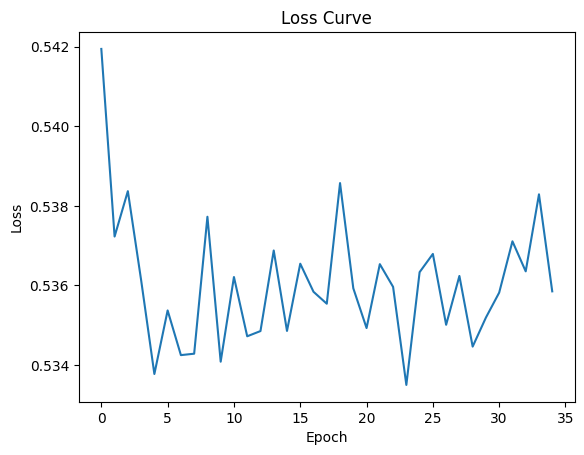

In [6]:
n_epoch = 35

model = sklearn.linear_model.SGDClassifier(
    loss='log_loss',
    random_state=42,
    max_iter=250,
    warm_start=True,
    shuffle=False,
    class_weight='balanced',
    learning_rate='constant',
    eta0=0.0001,
    penalty='l2',
    alpha=1,
    early_stopping=True
    )

loss_hist = []

for epoch in range(n_epoch):
    i = np.arange(len(scaled_train_features))
    random.shuffle(i) # Shuffles dataset every epoch
    features_shuffed = scaled_train_features[i]
    labels_shuffed = train_labels[i]

    model.fit(features_shuffed, labels_shuffed) # Train model

    # Calculate and record loss
    loss = sklearn.metrics.log_loss(labels_shuffed, model.predict_proba(features_shuffed))
    loss_hist.append(loss)

plt.plot(loss_hist)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Evaluating Model Accuracy
As we can see from the data table, the precision for real audio files is very low (34%), which means that the audio often confused more fake audio as real than real files correctly. This is however to be expected as we have a proportionally larger set of fake audio than real audio.

In [107]:
test_predictions = model.predict(scaled_test_features) 
report = pd.DataFrame(sklearn.metrics.classification_report(test_labels, test_predictions, target_names=['fake', 'real'], output_dict=True)).T
report['support'] = report.support.apply(int)
round_col = report.columns.difference(['support'])
report[round_col] = report[round_col].map(lambda x: f'{round(x*100, 2)}%')
report.style

,precision,recall,f1-score,support
fake,98.92%,79.88%,88.39%,63882
real,34.6%,92.43%,50.35%,7355
accuracy,81.18%,81.18%,81.18%,0
macro avg,66.76%,86.16%,69.37%,71237
weighted avg,92.28%,81.18%,84.46%,71237


# Generating a Confusion Matrix
From the test set, we can see that our model performed with around an 81% accuracy. We can also see the ratio of fake files wrongly classified as real to real files correctly classified as real which led to a low precision in real files.

Model Accuracy on the Test Set: 81.1783202549237%


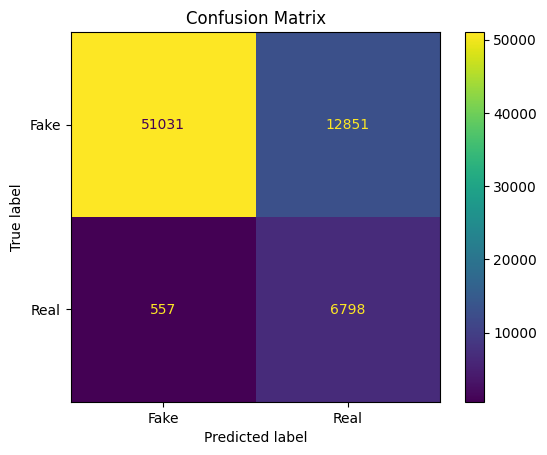

In [10]:
print(f'Model Accuracy on the Test Set: {100 * sklearn.metrics.accuracy_score(test_labels, test_predictions)}%')

disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, display_labels=['Fake', 'Real'], values_format='')

plt.title('Confusion Matrix')
plt.show()